In [1]:
InteractionsFileCaptureC='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/ChiCAGO_Calls_Adam/analysis/Chicago/CaptureC_SC_bait-bait.bed.gz'
#InteractionsFileHiC100='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/P-P_from_HiC/output/PP_SC_RE100.bed.gz'
#InteractionsFileHiC20='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/P-P_from_HiC/output/PP_SC_RE20.bed.gz'
#InteractionsFileHiC5='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/P-P_from_HiC/output/PP_SC_RE5.bed.gz'
PromoterFile='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/FIT-HI-C/promoters_flexible_repl_combined/data/reference_genomes/hg19/PromoterCapture_Digest_Human_HindIII_baits_ID.bed'
PROJDIR='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/kCCA'

In [1]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.stats.mstats import mquantiles
import scipy.stats as ss
import math
import scipy.linalg
import itertools
import copy
import random
import gzip
import testCrossValiFeatures as rcca
reload(rcca)

from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc, roc_curve
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
import networkx as nx

ImportError: No module named testCrossValiFeatures

In [ ]:
# builds adjacency matrix 
def BuildMatrixA(PromoterFile, InteractionsFile, datatype):

    REFrag_dict={}
    index=0
    # Assign indices to all promoter HindIII sites.
    for line in open(PromoterFile,'r'):
        words=line.rstrip().split()
        key=(words[0], words[1], words[2])
        if words[0] in ['chr1']: # only chr1
           REFrag_dict[key]=index
           index+=1

    # Initialize matrix (promoter x promoter)
    PPMatrix=np.zeros((len(REFrag_dict), len(REFrag_dict))) #  number of promoters in chr 1

    # Fill (promoter x promoter) matrix with q-values of promoter-promoter interaction
    max_score=0
    for line in gzip.open(InteractionsFile,'r'):
        words=line.rstrip().split()
            
    for line in gzip.open(InteractionsFile,'r'):
        words=line.rstrip().split()
        if words[0] in ['chr1']: #only chr1
            i=REFrag_dict[(words[0], words[1], words[2])]
            j=REFrag_dict[(words[3], words[4], words[5])]


            q_values=float(words[6])  # for CaptureC
            if PPMatrix[i,j] != 0:
                PPMatrix[i,j]=PPMatrix[i,j]/2+q_values/2
                PPMatrix[j,i]=PPMatrix[j,i]/2+q_values/2
            else:
                PPMatrix[i,j]=q_values
                PPMatrix[j,i]=q_values
                    # take -1*log(Q) for non-zero entries
    #mask = PPMatrix != 0
    #PPMatrix[mask] = np.log10(PPMatrix[mask])*(-1)

    # list of non-zero q-values
    q_values=list(filter((0.0).__ne__,list(itertools.chain.from_iterable(np.array(PPMatrix).tolist()))))

    # Some tests:
    print "Some tests on adjacency matrix:"
    # 1. Check if the matrix is symmetric:
    if (PPMatrix.transpose() == PPMatrix).all() == True:
        print "Adjacency matrix is symmetric"
    # 2. Print out average q-values:
    print "Average q-value with zeros: ", str(np.average(PPMatrix))
    print "Average q-value w/o zeros: ", np.mean(q_values)

    # Print distribution of q-values
    plt.hist(q_values)
    plt.show()

    return PPMatrix

In [ ]:
def printMatrix(Matrix, ylabel, QuantileValue, LowerUpperLimit, title=''):
    #vmaxLim=mquantiles(Matrix,[0.99])[0]
    Lim=mquantiles(Matrix,[QuantileValue])[0]
    print Matrix.max()
    print np.shape(Matrix)
    print "Limit:", Lim
    fig, ax = plt.subplots()
    fig.subplots_adjust(top=0.8)
    if LowerUpperLimit == 'lower':
        m = ax.matshow(Matrix, origin="bottom", #norm=colors.LogNorm(),  #norm=colors.SymLogNorm(1),
               cmap="RdYlBu_r", vmin=Lim)
    else:
        m = ax.matshow(Matrix, origin="bottom", #norm=colors.LogNorm(),  #norm=colors.SymLogNorm(1),
               cmap="RdYlBu_r", vmax=Lim) # cmap="RdYlBu_r"


    ax.axhline(-0.5, color="#000000", linewidth=1, linestyle="--")
    ax.axvline(-0.5, color="#000000", linewidth=1, linestyle="--")

    cb = fig.colorbar(m)
    cb.set_label(ylabel)

    ax.set_ylim((-0.5, len(Matrix) - 0.5))
    ax.set_xlim((-0.5, len(Matrix) - 0.5))
    
    plt.title(title)
    plt.show()
    return


In [ ]:
# builds feature vector 
def BuildFeatureVector(PromoterFile, FeatureVectorFile, dataName):

    REFrag_dict={}
    index=0
    # Assign indices to all promoter HindIII sites.
    for line in open(PromoterFile,'r'):
        words=line.rstrip().split()
        key=(words[0], words[1], words[2])
        if words[0] in ['chr1']: # only chr1
           REFrag_dict[key]=index
           index+=1

    # Initialize vector (promoters only)
    vector=np.zeros((len(REFrag_dict),)) #  number of promoters in chr 1

    for line in gzip.open(FeatureVectorFile,'r'):
        words=line.rstrip().split()
        if words[0] in ['chr1']: #only chr1
            value=words[3]
            i=REFrag_dict[(words[0], words[1], words[2])]
            vector[i]=value

    # list of non-zero q-values
    nonzero_values=filter(lambda a: a != 0, np.array(vector).reshape(-1,).tolist())

    # Print out average q-values:
    print "Average value with zeros: ", str(np.average(vector))
    print "Average q-value w/o zeros: ", np.mean(nonzero_values)

    # Print distribution of q-values
    plt.hist(vector)
    plt.title(str(dataName))
    plt.show()

    return vector

In [ ]:
def set_diag_to_value(matrix, value):
    np.fill_diagonal(matrix, value)
    return matrix

In [ ]:
def binarize(matrix, thres=0.5):
    matrix=copy.copy(matrix)
    matrix[matrix <= thres] = 0
    matrix[matrix > thres] = 1    
    return matrix

In [ ]:
def demean(d): return d-d.mean(0) 
def zscore(d): return (d-d.mean(0))/d.std(0)

In [ ]:
#test proportion is computed as total-train
def shuffle_nodes (vector_1d, trainProportion, valiProportion):
    total_num=len(vector_1d)
    train_num=int(trainProportion*total_num)
    vali_num=int(valiProportion*total_num)
    test_num=total_num-train_num-vali_num
    if test_num<=0:
        print "Nothing in the test set!!!"
    print "Training set: "+str(train_num)
    print "Validation set: "+str(vali_num)
    print "Test set: "+str(test_num)
    #decide the random split of nodes
    nodes=[i for i in range(len(vector_1d))]
    shuffled_nodes=copy.copy(nodes)
    random.shuffle(shuffled_nodes)
    train_nodes=np.array(shuffled_nodes[:train_num])
    vali_nodes=np.array(shuffled_nodes[train_num:train_num+vali_num])
    test_nodes=np.array(shuffled_nodes[train_num+vali_num:])
    return train_nodes, vali_nodes, test_nodes
# shuffle and split nodes 
def train_vali_test_3d(data_3d, train_nodes, vali_nodes, test_nodes):
    train_set=data_3d[train_nodes, :, :]
    vali_set=data_3d[vali_nodes, :, :]
    test_set=data_3d[test_nodes, :, :]
    return train_set, vali_set, test_set
def train_vali_test_2d(indx_2d, train_nodes, vali_nodes, test_nodes):
    indx_train=indx_2d[train_nodes]
    indx_vali=indx_2d[vali_nodes]
    indx_test=indx_2d[test_nodes]
    return indx_train, indx_vali, indx_test
def train_vali_test_1d(labels_1d, train_nodes, vali_nodes, test_nodes):
    labels_train=labels_1d[train_nodes]
    labels_vali=labels_1d[vali_nodes]
    labels_test=labels_1d[test_nodes]
    return labels_train, labels_vali, labels_test

In [ ]:
def build_distance_for_node(PromoterFile): 
    REsiteMids=[]
    for line in open(PromoterFile,'r'):
        words=line.rstrip().split()
        if words[0] in ['chr1']: # only chr1
            REsiteMids.append((int(words[2])+int(words[1]))/2)
    return np.array((REsiteMids))

In [ ]:
distance_for_node=build_distance_for_node(PromoterFile)

In [ ]:
CaptureC = BuildMatrixA(PromoterFile, InteractionsFileCaptureC, 'CaptureC')

In [ ]:
CaptureC_labels=binarize(set_diag_to_value(CaptureC, CaptureC.max()))

In [ ]:
printMatrix(CaptureC_labels, '', 1, 1, title='')

In [ ]:
subset=CaptureC_labels[[i for i in range(100)]][:, [i for i in range(100)]]
printMatrix(subset, '', 1, i, title='')

# All Data

In [24]:
def get_data(data, train_nodes, vali_nodes, test_nodes):    
    features_path='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/peaks_at_promoters/'
    feature_sets=['thres5_max', 'thres5_mean', 'thres2_max', 'thres2_mean', 'reads']

    for feature_set in feature_sets:

        atac=features_path+'output_'+feature_set+'/'+'atac.gz'
        #TFs
        ctcf=features_path+'output_'+feature_set+'/'+'CTCF.gz'
        pol3=features_path+'output_'+feature_set+'/'+'PolII.gz'
        TP63=features_path+'output_'+feature_set+'/'+'TP63.gz'
        LSD1=features_path+'output_'+feature_set+'/'+'LSD1.gz'
        #histone
        H3K27ac=features_path+'output_'+feature_set+'/'+'H3K27ac.gz'
        H3K27me3=features_path+'output_'+feature_set+'/'+'H3K27me3.gz'
        H3K4me1=features_path+'output_'+feature_set+'/'+'H3K4me1.gz'
        H3K4me3=features_path+'output_'+feature_set+'/'+'H3K4me3.gz'
        H3K9ac=features_path+'output_'+feature_set+'/'+'H3K9ac.gz'

        VectorATAC=BuildFeatureVector(PromoterFile, atac, 'atac')

        VectorCTCF=BuildFeatureVector(PromoterFile, ctcf, 'ctcf')
        VectorPOL3=BuildFeatureVector(PromoterFile, pol3, 'pol3')
        VectorTP63=BuildFeatureVector(PromoterFile, TP63, 'TP63')
        VectorLSD1=BuildFeatureVector(PromoterFile, LSD1, 'LSD1')

        VectorH3K27ac=BuildFeatureVector(PromoterFile, H3K27ac, 'H3K27ac')
        VectorH3K27me3=BuildFeatureVector(PromoterFile, H3K27me3, 'H3K27me3')
        VectorH3K4me1=BuildFeatureVector(PromoterFile, H3K4me1, 'H3K4me1')
        VectorH3K4me3=BuildFeatureVector(PromoterFile, H3K4me3, 'H3K4me3')
        VectorH3K9ac=BuildFeatureVector(PromoterFile, H3K9ac, 'H3K9ac')

        FeatureVectorDistance = np.vstack((VectorATAC, VectorCTCF, VectorPOL3, VectorTP63, VectorLSD1, VectorH3K27ac, VectorH3K27me3, VectorH3K4me1, VectorH3K4me3, VectorH3K9ac, distance_for_node)).T

        NumberOfNodes=CaptureC_labels.shape[0]
        if data=='all':
            data_array=np.zeros((NumberOfNodes**2,11,2))
            k1=0
            for i in range(NumberOfNodes):
                for j in range(NumberOfNodes):
                    data_array[k1,:,0]=FeatureVectorDistance[i,:]
                    data_array[k1,:,1]=FeatureVectorDistance[j,:]
                    k1+=1
        if data=='upperTriangle':
            data_array=np.zeros(((NumberOfNodes**2+NumberOfNodes)/2,11,2))
            k1=0
            for i in range(NumberOfNodes):
                for j in range(i+1):
                    data_array[k1,:,0]=FeatureVectorDistance[i,:]
                    data_array[k1,:,1]=FeatureVectorDistance[j,:]
                    k1+=1
        
        if data=='upperTriangle_noDiag':
            data_array=np.zeros(((NumberOfNodes**2+NumberOfNodes)/2,11,2))
            k1=0
            for i in range(NumberOfNodes):
                for j in range(i+1):
                    if i!=j:
                        data_array[k1,:,0]=FeatureVectorDistance[i,:]
                        data_array[k1,:,1]=FeatureVectorDistance[j,:]
                        k1+=1
        train_set, vali_set, test_set = train_vali_test_3d(data_array, train_nodes, vali_nodes, test_nodes)
    
        np.save('train_set_'+str(data)+'_'+feature_set+'.npy', train_set) 
        np.save('vali_set_'+str(data)+'_'+feature_set+'.npy', vali_set) 
        np.save('test_set_'+str(data)+'_'+feature_set+'.npy', test_set) 
    
        print data, feature_set
        print data_array.shape
        print train_set.shape
        print vali_set.shape
        print test_set.shape


Training set: 2580992
Validation set: 1548595
Test set: 1032397
Average value with zeros:  21.9245984551
Average q-value w/o zeros:  33.3418257631


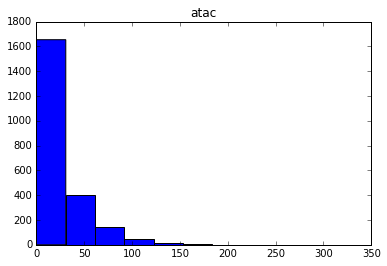

Average value with zeros:  30.8321433979
Average q-value w/o zeros:  63.798387796


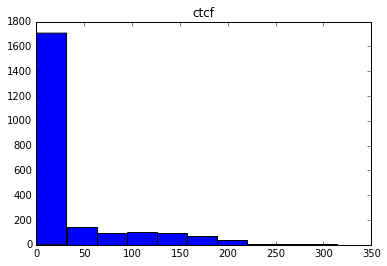

Average value with zeros:  18.2601188732
Average q-value w/o zeros:  35.2780527891


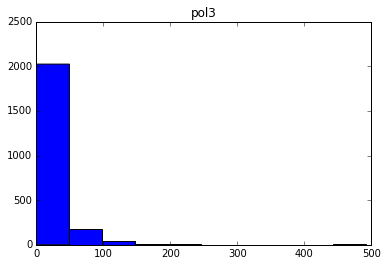

Average value with zeros:  6.97454184859
Average q-value w/o zeros:  17.6657291862


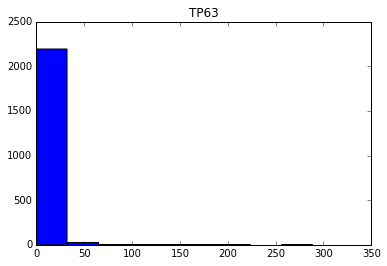

Average value with zeros:  0.828355180458
Average q-value w/o zeros:  9.04818735577


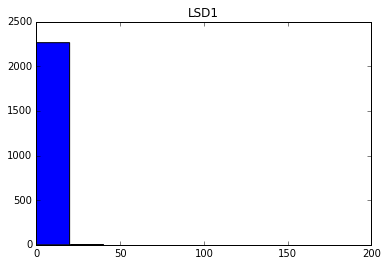

Average value with zeros:  29.1659232835
Average q-value w/o zeros:  55.7316885618


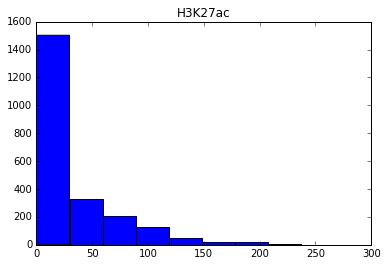

Average value with zeros:  3.3275984419
Average q-value w/o zeros:  16.0175925


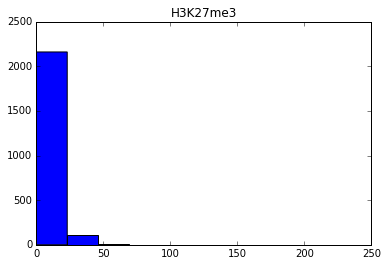

Average value with zeros:  10.5938546083
Average q-value w/o zeros:  15.7418166579


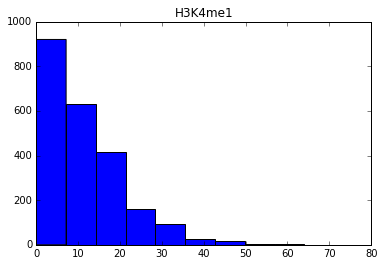

Average value with zeros:  105.891611549
Average q-value w/o zeros:  179.809971181


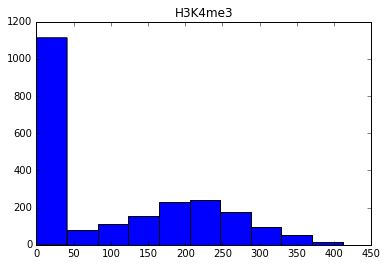

Average value with zeros:  16.4996693574
Average q-value w/o zeros:  30.6268372386


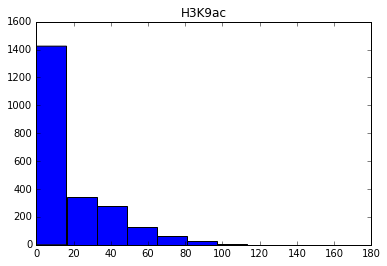

all thres5_max
(5161984, 11, 2)
(2580992, 11, 2)
(1548595, 11, 2)
(1032397, 11, 2)
Average value with zeros:  19.4309888908
Average q-value w/o zeros:  29.5496698527


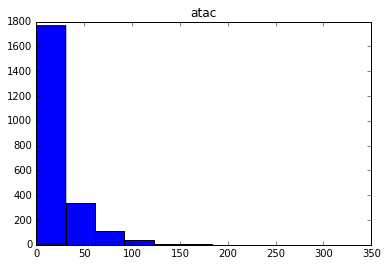

Average value with zeros:  26.5778645026
Average q-value w/o zeros:  54.9953626138


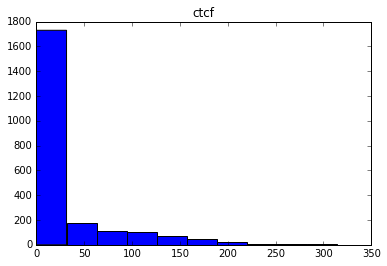

Average value with zeros:  16.6048905766
Average q-value w/o zeros:  32.0801967602


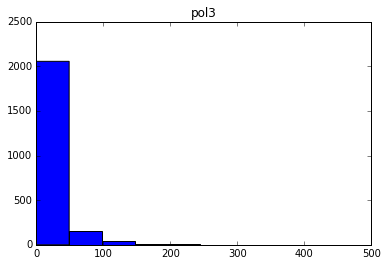

Average value with zeros:  6.33724290933
Average q-value w/o zeros:  16.0515227313


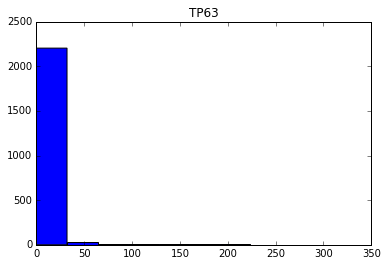

Average value with zeros:  0.813998419894
Average q-value w/o zeros:  8.89136735577


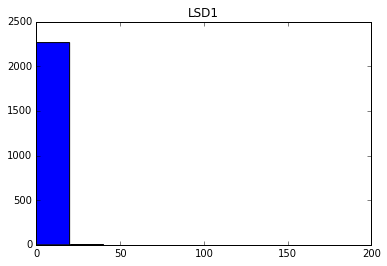

Average value with zeros:  26.6054393266
Average q-value w/o zeros:  50.8389891926


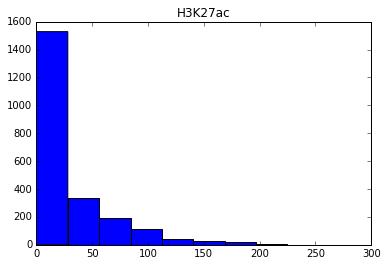

Average value with zeros:  3.09072320423
Average q-value w/o zeros:  14.8773794915


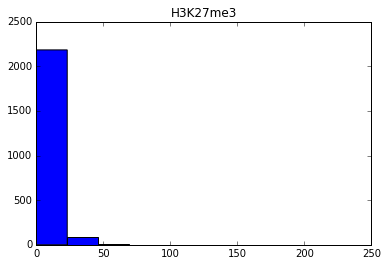

Average value with zeros:  9.02258352993
Average q-value w/o zeros:  13.4070044343


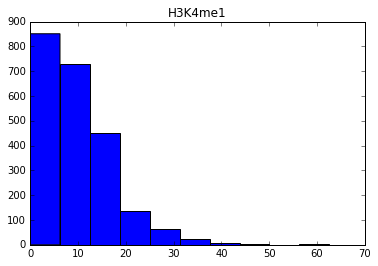

Average value with zeros:  102.059685889
Average q-value w/o zeros:  173.303143752


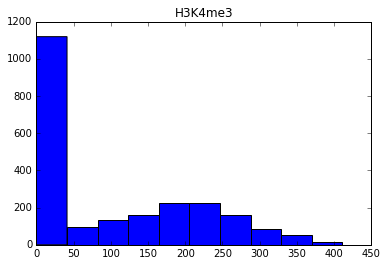

Average value with zeros:  14.807954529
Average q-value w/o zeros:  27.4866606944


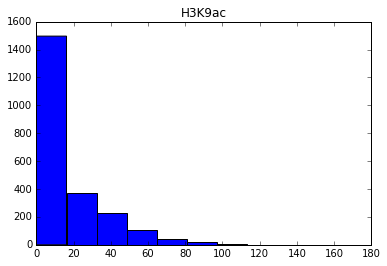

all thres5_mean
(5161984, 11, 2)
(2580992, 11, 2)
(1548595, 11, 2)
(1032397, 11, 2)
Average value with zeros:  22.2088260871
Average q-value w/o zeros:  30.5438576695


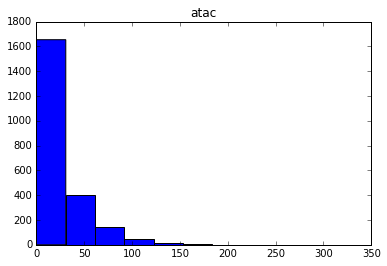

Average value with zeros:  31.1869118882
Average q-value w/o zeros:  54.8850997754


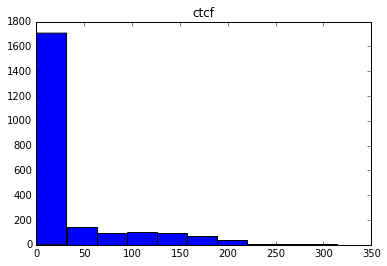

Average value with zeros:  18.4484494586
Average q-value w/o zeros:  32.7459977891


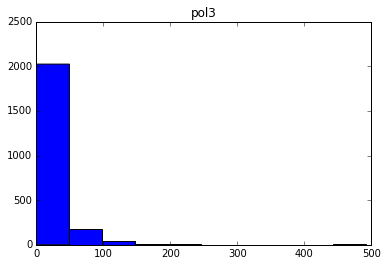

Average value with zeros:  7.85520705106
Average q-value w/o zeros:  12.7569910079


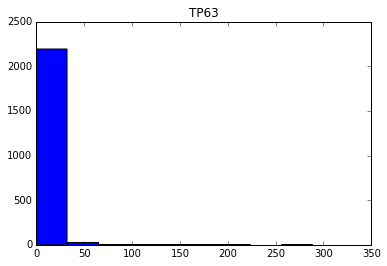

Average value with zeros:  1.2637209419
Average q-value w/o zeros:  6.21466229437


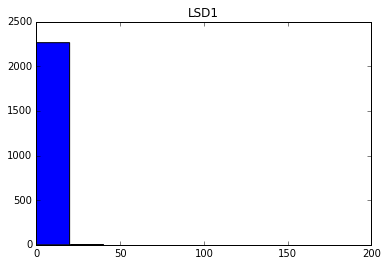

Average value with zeros:  29.2616054665
Average q-value w/o zeros:  53.5716096857


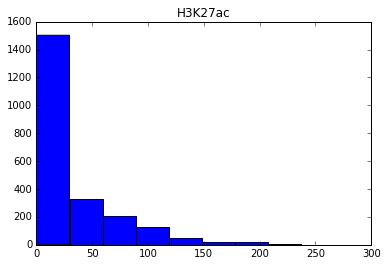

Average value with zeros:  3.58732474912
Average q-value w/o zeros:  13.2742700814


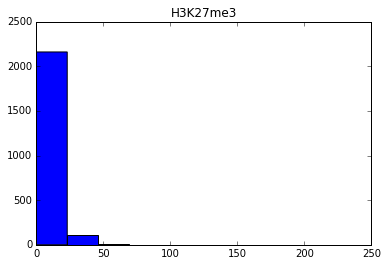

Average value with zeros:  10.7180672403
Average q-value w/o zeros:  15.2577999812


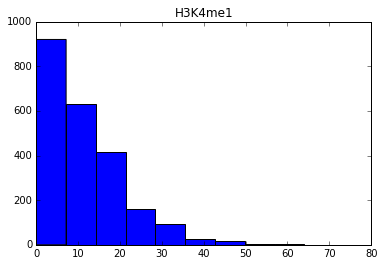

Average value with zeros:  105.933431734
Average q-value w/o zeros:  176.841114548


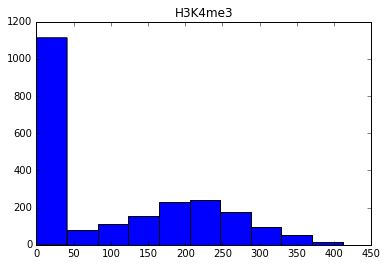

Average value with zeros:  16.7188760387
Average q-value w/o zeros:  28.2208665379


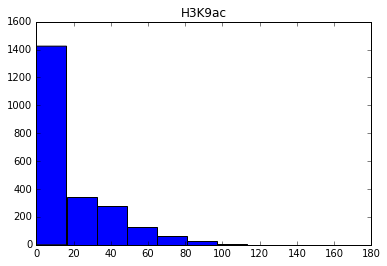

all thres2_max
(5161984, 11, 2)
(2580992, 11, 2)
(1548595, 11, 2)
(1032397, 11, 2)
Average value with zeros:  19.1889162192
Average q-value w/o zeros:  26.3905675847


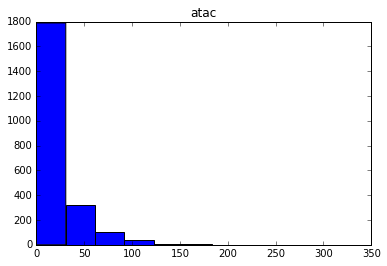

Average value with zeros:  26.138870559
Average q-value w/o zeros:  46.0011726646


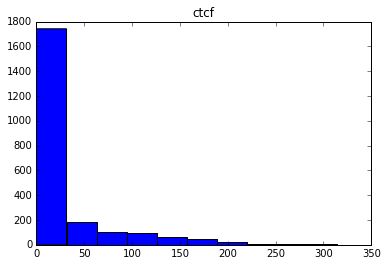

Average value with zeros:  16.41072375
Average q-value w/o zeros:  29.1290346562


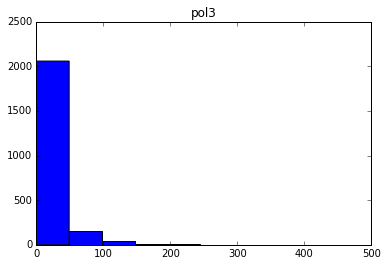

Average value with zeros:  6.64786035651
Average q-value w/o zeros:  10.7962392638


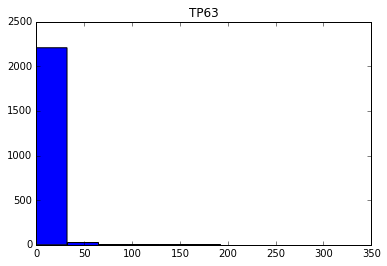

Average value with zeros:  1.21961975792
Average q-value w/o zeros:  5.99778374459


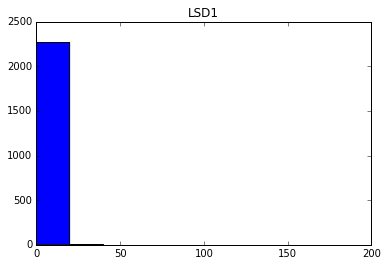

Average value with zeros:  26.4675582086
Average q-value w/o zeros:  48.456319299


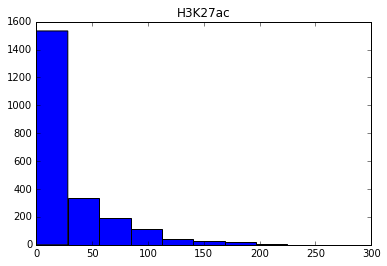

Average value with zeros:  3.21990819982
Average q-value w/o zeros:  11.9147091694


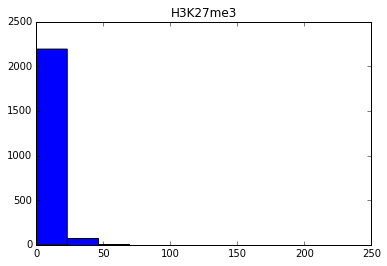

Average value with zeros:  8.79946596391
Average q-value w/o zeros:  12.5265580639


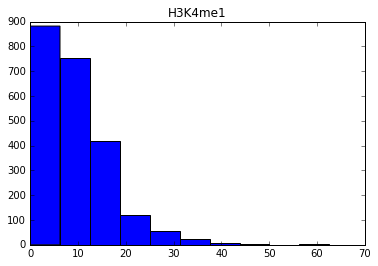

Average value with zeros:  101.908996184
Average q-value w/o zeros:  170.122879743


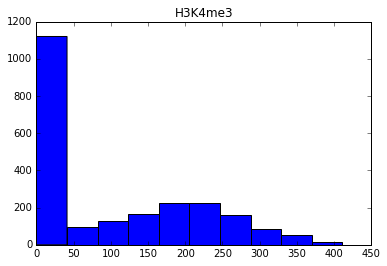

Average value with zeros:  14.533674309
Average q-value w/o zeros:  24.532323945


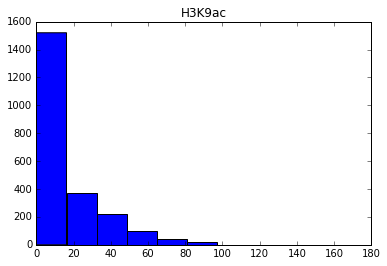

all thres2_mean
(5161984, 11, 2)
(2580992, 11, 2)
(1548595, 11, 2)
(1032397, 11, 2)
Average value with zeros:  116.543573944
Average q-value w/o zeros:  117.058797524


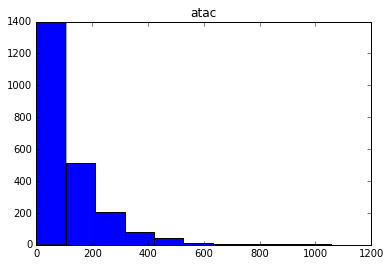

Average value with zeros:  92.8001760563
Average q-value w/o zeros:  93.0048522276


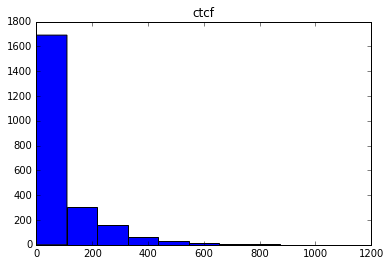

Average value with zeros:  241.500440141
Average q-value w/o zeros:  241.500440141


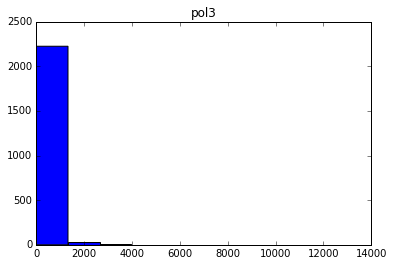

Average value with zeros:  23.3622359155
Average q-value w/o zeros:  24.9666039511


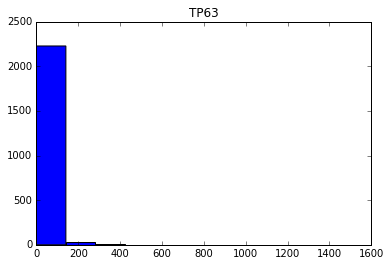

Average value with zeros:  40.9784330986
Average q-value w/o zeros:  41.0145374449


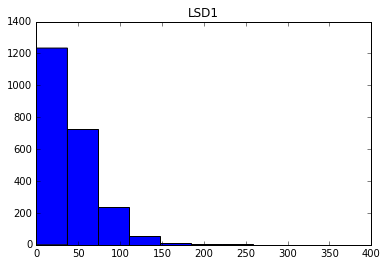

Average value with zeros:  297.378080986
Average q-value w/o zeros:  297.378080986


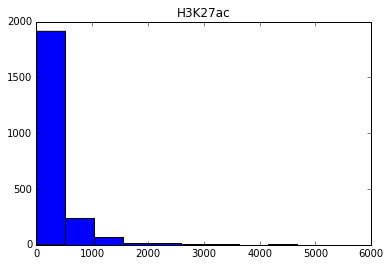

Average value with zeros:  239.871038732
Average q-value w/o zeros:  239.871038732


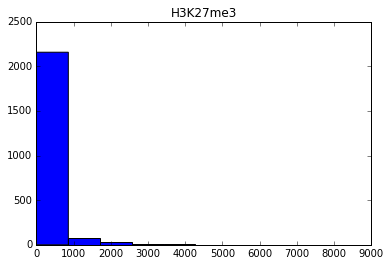

Average value with zeros:  209.150528169
Average q-value w/o zeros:  209.611821791


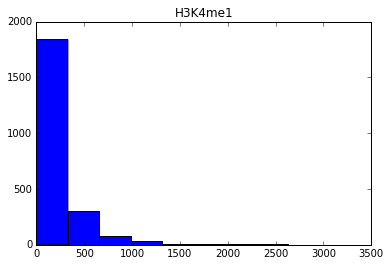

Average value with zeros:  968.580545775
Average q-value w/o zeros:  969.007045354


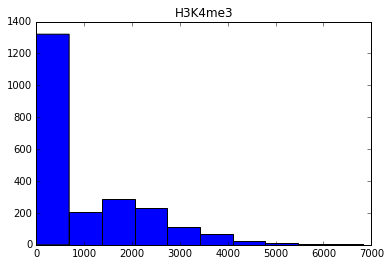

Average value with zeros:  176.617957746
Average q-value w/o zeros:  176.617957746


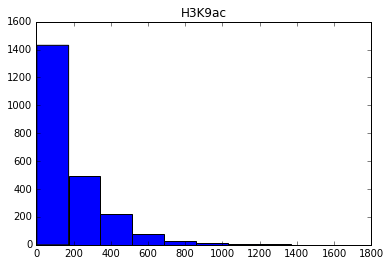

all reads
(5161984, 11, 2)
(2580992, 11, 2)
(1548595, 11, 2)
(1032397, 11, 2)
Training set: 1291064
Validation set: 774638
Test set: 516426
Average value with zeros:  21.9245984551
Average q-value w/o zeros:  33.3418257631


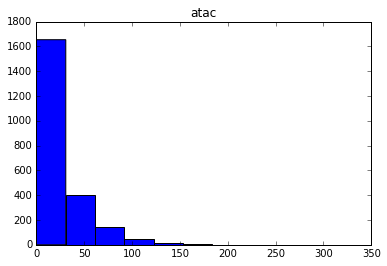

Average value with zeros:  30.8321433979
Average q-value w/o zeros:  63.798387796


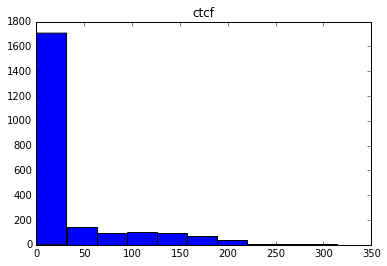

Average value with zeros:  18.2601188732
Average q-value w/o zeros:  35.2780527891


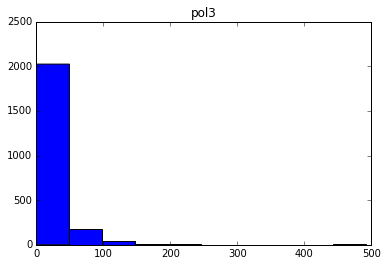

Average value with zeros:  6.97454184859
Average q-value w/o zeros:  17.6657291862


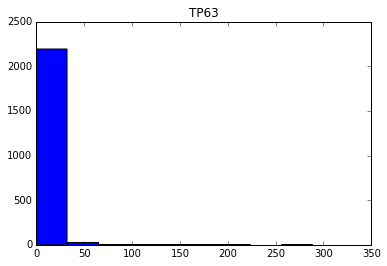

Average value with zeros:  0.828355180458
Average q-value w/o zeros:  9.04818735577


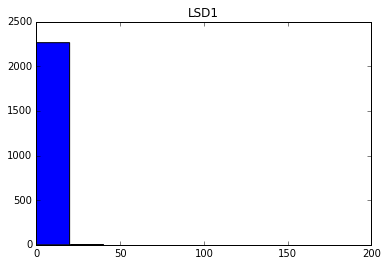

Average value with zeros:  29.1659232835
Average q-value w/o zeros:  55.7316885618


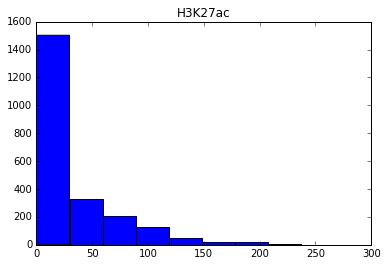

Average value with zeros:  3.3275984419
Average q-value w/o zeros:  16.0175925


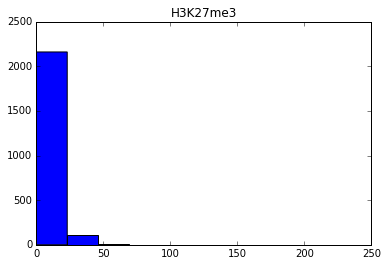

Average value with zeros:  10.5938546083
Average q-value w/o zeros:  15.7418166579


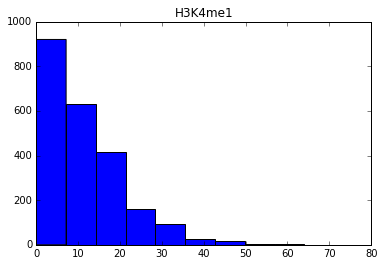

Average value with zeros:  105.891611549
Average q-value w/o zeros:  179.809971181


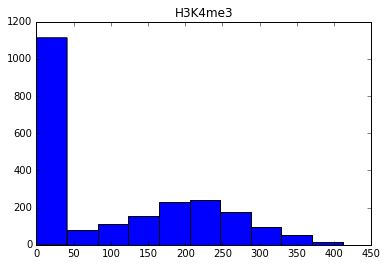

Average value with zeros:  16.4996693574
Average q-value w/o zeros:  30.6268372386


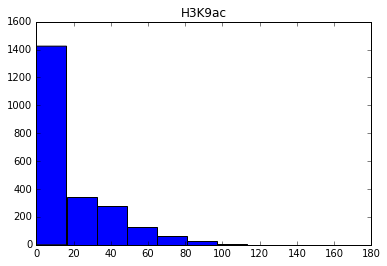

upperTriangle thres5_max
(2582128, 11, 2)
(1291064, 11, 2)
(774638, 11, 2)
(516426, 11, 2)
Average value with zeros:  19.4309888908
Average q-value w/o zeros:  29.5496698527


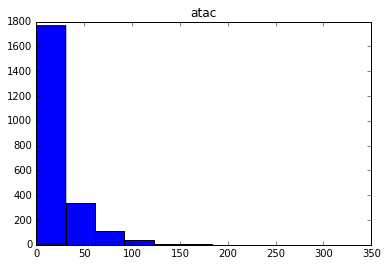

Average value with zeros:  26.5778645026
Average q-value w/o zeros:  54.9953626138


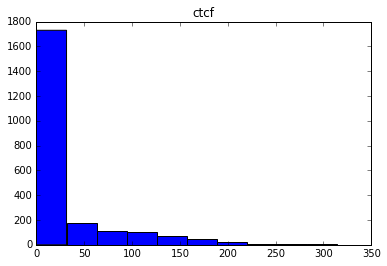

Average value with zeros:  16.6048905766
Average q-value w/o zeros:  32.0801967602


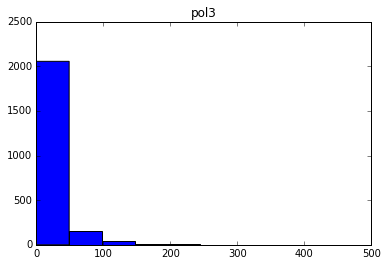

Average value with zeros:  6.33724290933
Average q-value w/o zeros:  16.0515227313


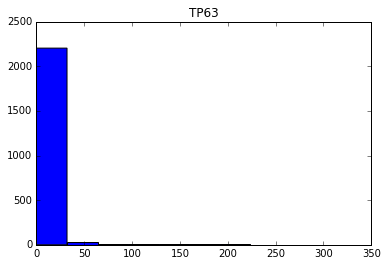

Average value with zeros:  0.813998419894
Average q-value w/o zeros:  8.89136735577


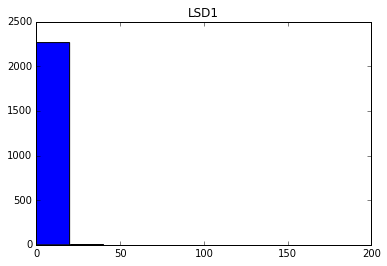

Average value with zeros:  26.6054393266
Average q-value w/o zeros:  50.8389891926


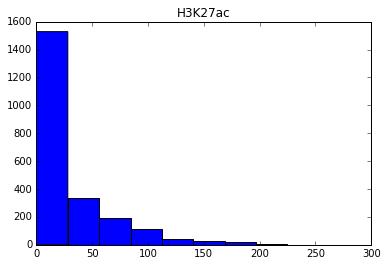

Average value with zeros:  3.09072320423
Average q-value w/o zeros:  14.8773794915


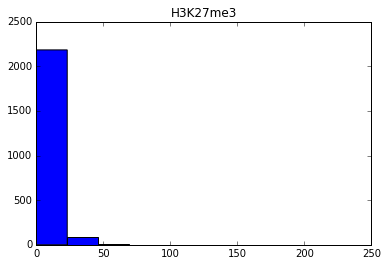

Average value with zeros:  9.02258352993
Average q-value w/o zeros:  13.4070044343


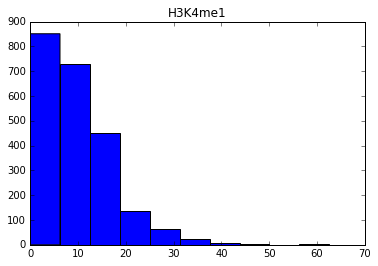

Average value with zeros:  102.059685889
Average q-value w/o zeros:  173.303143752


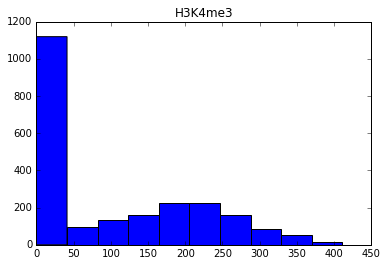

Average value with zeros:  14.807954529
Average q-value w/o zeros:  27.4866606944


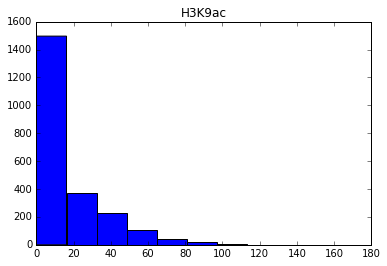

upperTriangle thres5_mean
(2582128, 11, 2)
(1291064, 11, 2)
(774638, 11, 2)
(516426, 11, 2)
Average value with zeros:  22.2088260871
Average q-value w/o zeros:  30.5438576695


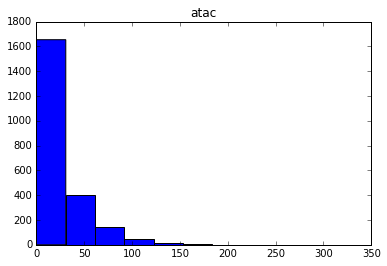

Average value with zeros:  31.1869118882
Average q-value w/o zeros:  54.8850997754


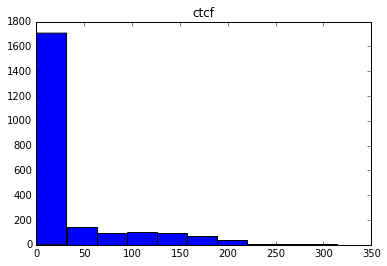

Average value with zeros:  18.4484494586
Average q-value w/o zeros:  32.7459977891


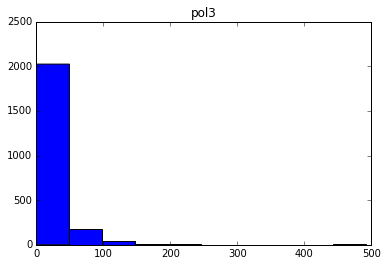

Average value with zeros:  7.85520705106
Average q-value w/o zeros:  12.7569910079


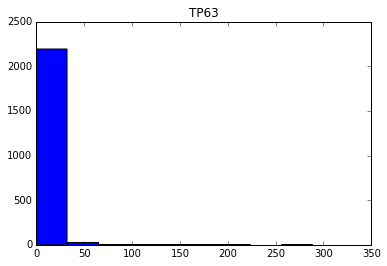

Average value with zeros:  1.2637209419
Average q-value w/o zeros:  6.21466229437


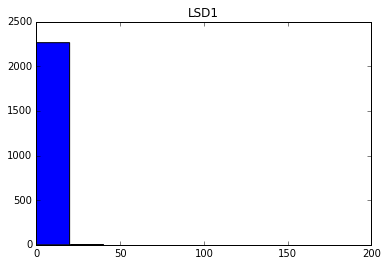

Average value with zeros:  29.2616054665
Average q-value w/o zeros:  53.5716096857


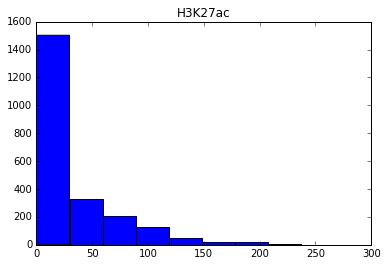

Average value with zeros:  3.58732474912
Average q-value w/o zeros:  13.2742700814


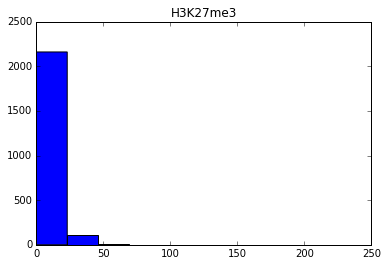

Average value with zeros:  10.7180672403
Average q-value w/o zeros:  15.2577999812


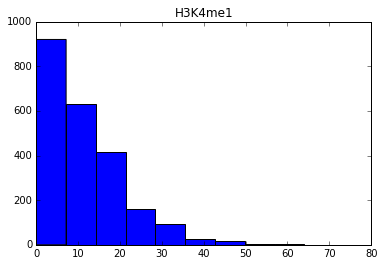

Average value with zeros:  105.933431734
Average q-value w/o zeros:  176.841114548


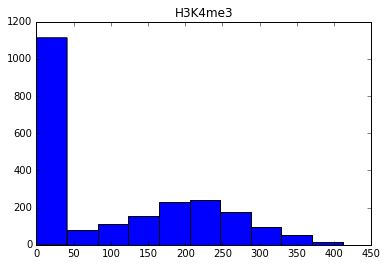

Average value with zeros:  16.7188760387
Average q-value w/o zeros:  28.2208665379


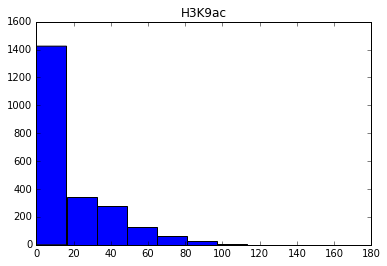

upperTriangle thres2_max
(2582128, 11, 2)
(1291064, 11, 2)
(774638, 11, 2)
(516426, 11, 2)
Average value with zeros:  19.1889162192
Average q-value w/o zeros:  26.3905675847


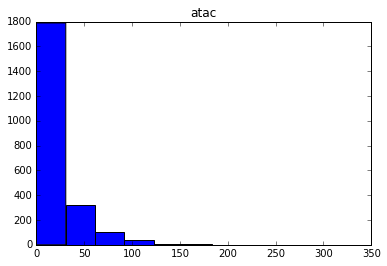

Average value with zeros:  26.138870559
Average q-value w/o zeros:  46.0011726646


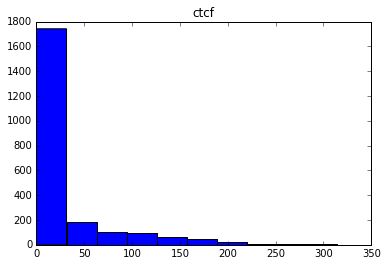

Average value with zeros:  16.41072375
Average q-value w/o zeros:  29.1290346562


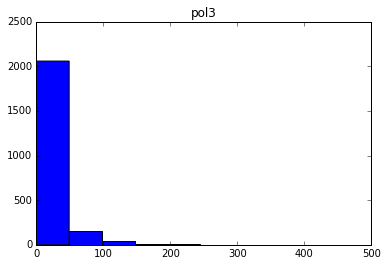

Average value with zeros:  6.64786035651
Average q-value w/o zeros:  10.7962392638


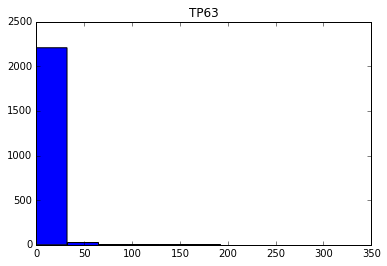

Average value with zeros:  1.21961975792
Average q-value w/o zeros:  5.99778374459


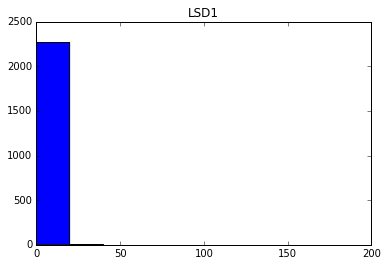

Average value with zeros:  26.4675582086
Average q-value w/o zeros:  48.456319299


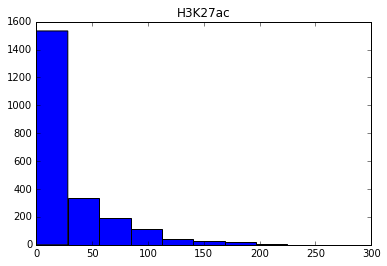

Average value with zeros:  3.21990819982
Average q-value w/o zeros:  11.9147091694


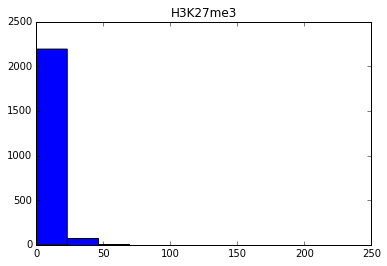

Average value with zeros:  8.79946596391
Average q-value w/o zeros:  12.5265580639


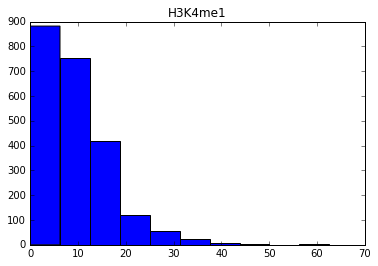

Average value with zeros:  101.908996184
Average q-value w/o zeros:  170.122879743


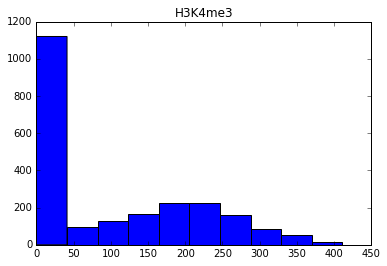

Average value with zeros:  14.533674309
Average q-value w/o zeros:  24.532323945


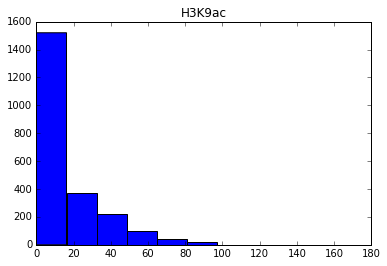

upperTriangle thres2_mean
(2582128, 11, 2)
(1291064, 11, 2)
(774638, 11, 2)
(516426, 11, 2)
Average value with zeros:  116.543573944
Average q-value w/o zeros:  117.058797524


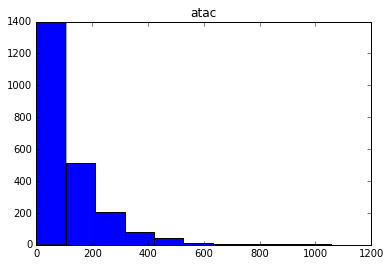

Average value with zeros:  92.8001760563
Average q-value w/o zeros:  93.0048522276


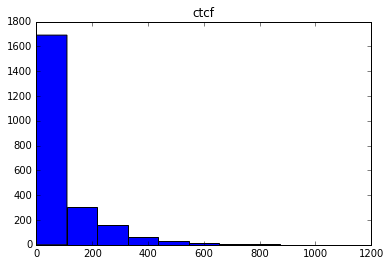

Average value with zeros:  241.500440141
Average q-value w/o zeros:  241.500440141


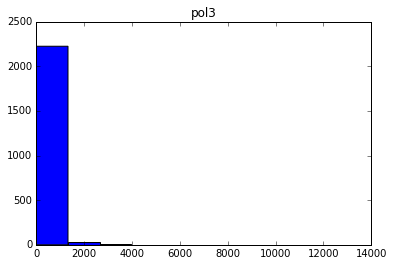

Average value with zeros:  23.3622359155
Average q-value w/o zeros:  24.9666039511


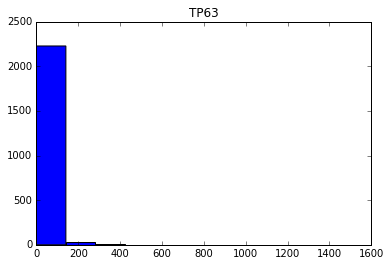

Average value with zeros:  40.9784330986
Average q-value w/o zeros:  41.0145374449


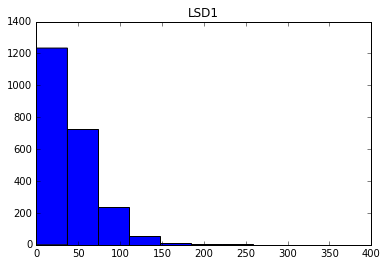

Average value with zeros:  297.378080986
Average q-value w/o zeros:  297.378080986


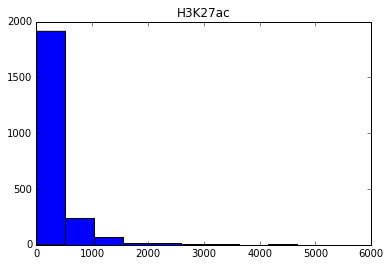

Average value with zeros:  239.871038732
Average q-value w/o zeros:  239.871038732


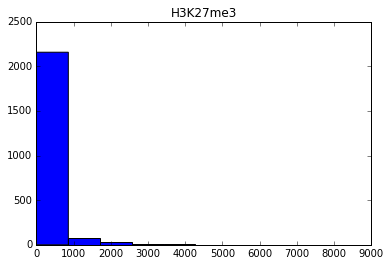

Average value with zeros:  209.150528169
Average q-value w/o zeros:  209.611821791


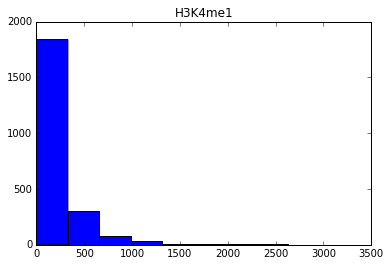

Average value with zeros:  968.580545775
Average q-value w/o zeros:  969.007045354


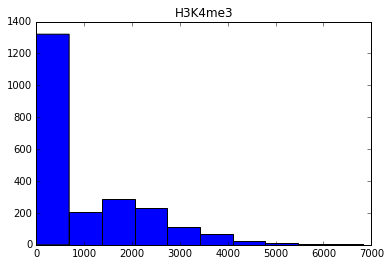

Average value with zeros:  176.617957746
Average q-value w/o zeros:  176.617957746


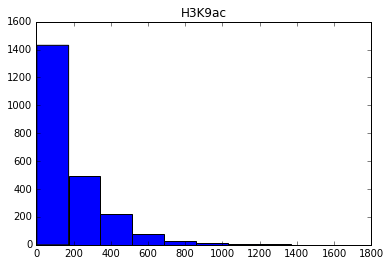

upperTriangle reads
(2582128, 11, 2)
(1291064, 11, 2)
(774638, 11, 2)
(516426, 11, 2)
Training set: 1289928
Validation set: 773956
Test set: 515972
Average value with zeros:  21.9245984551
Average q-value w/o zeros:  33.3418257631


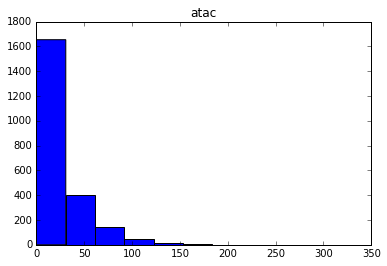

Average value with zeros:  30.8321433979
Average q-value w/o zeros:  63.798387796


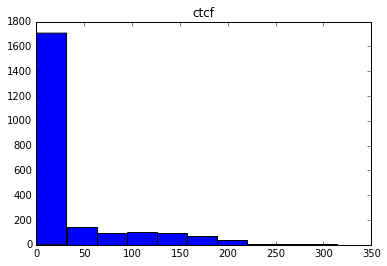

Average value with zeros:  18.2601188732
Average q-value w/o zeros:  35.2780527891


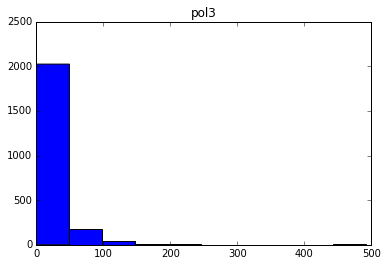

Average value with zeros:  6.97454184859
Average q-value w/o zeros:  17.6657291862


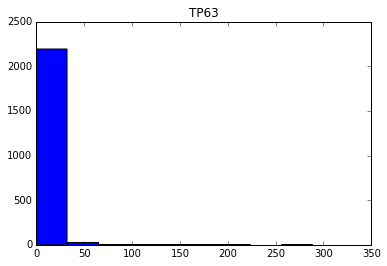

Average value with zeros:  0.828355180458
Average q-value w/o zeros:  9.04818735577


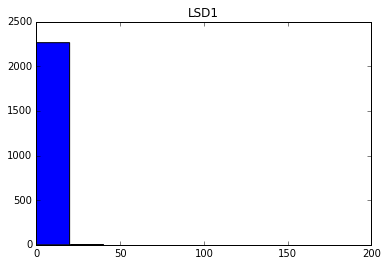

Average value with zeros:  29.1659232835
Average q-value w/o zeros:  55.7316885618


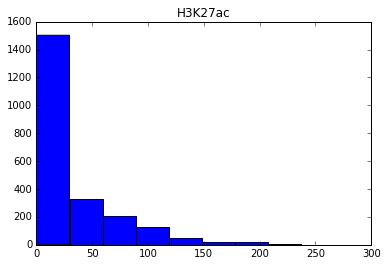

Average value with zeros:  3.3275984419
Average q-value w/o zeros:  16.0175925


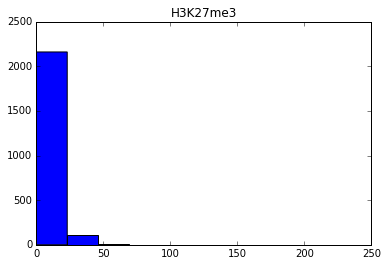

Average value with zeros:  10.5938546083
Average q-value w/o zeros:  15.7418166579


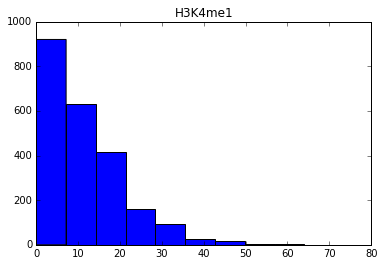

Average value with zeros:  105.891611549
Average q-value w/o zeros:  179.809971181


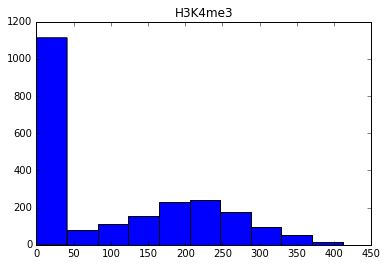

Average value with zeros:  16.4996693574
Average q-value w/o zeros:  30.6268372386


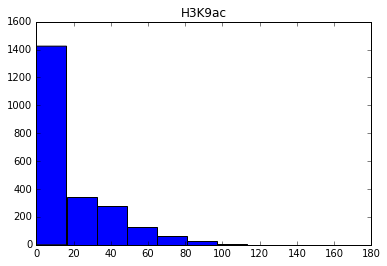

upperTriangle_noDiag thres5_max
(2582128, 11, 2)
(1289928, 11, 2)
(773956, 11, 2)
(515972, 11, 2)
Average value with zeros:  19.4309888908
Average q-value w/o zeros:  29.5496698527


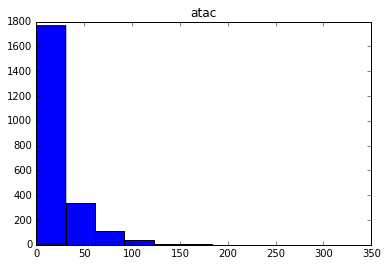

Average value with zeros:  26.5778645026
Average q-value w/o zeros:  54.9953626138


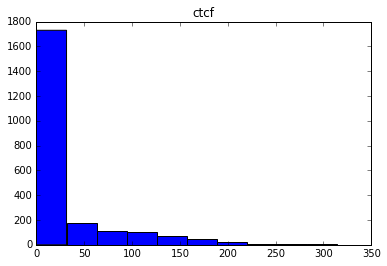

Average value with zeros:  16.6048905766
Average q-value w/o zeros:  32.0801967602


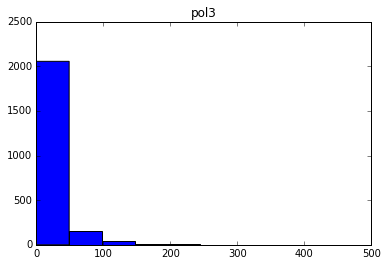

Average value with zeros:  6.33724290933
Average q-value w/o zeros:  16.0515227313


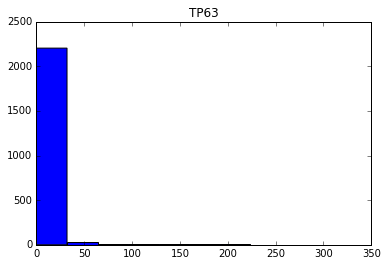

Average value with zeros:  0.813998419894
Average q-value w/o zeros:  8.89136735577


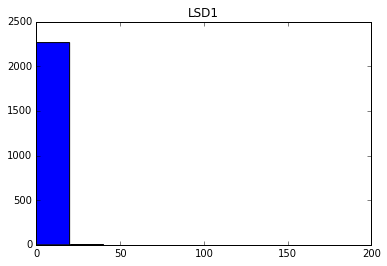

Average value with zeros:  26.6054393266
Average q-value w/o zeros:  50.8389891926


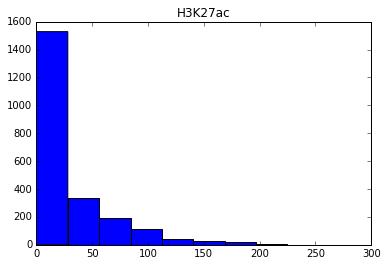

Average value with zeros:  3.09072320423
Average q-value w/o zeros:  14.8773794915


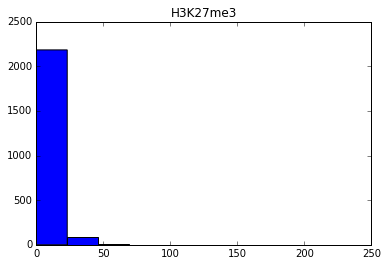

Average value with zeros:  9.02258352993
Average q-value w/o zeros:  13.4070044343


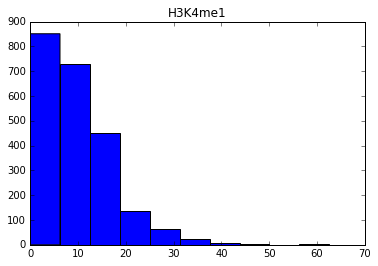

Average value with zeros:  102.059685889
Average q-value w/o zeros:  173.303143752


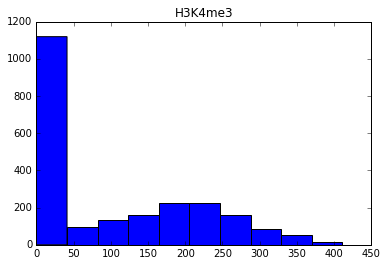

Average value with zeros:  14.807954529
Average q-value w/o zeros:  27.4866606944


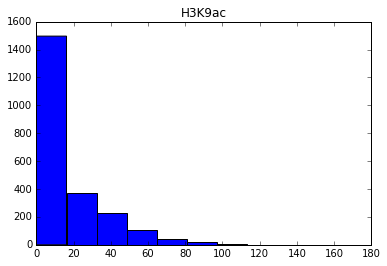

upperTriangle_noDiag thres5_mean
(2582128, 11, 2)
(1289928, 11, 2)
(773956, 11, 2)
(515972, 11, 2)
Average value with zeros:  22.2088260871
Average q-value w/o zeros:  30.5438576695


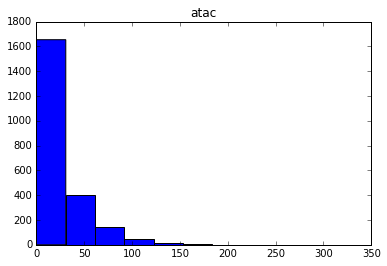

Average value with zeros:  31.1869118882
Average q-value w/o zeros:  54.8850997754


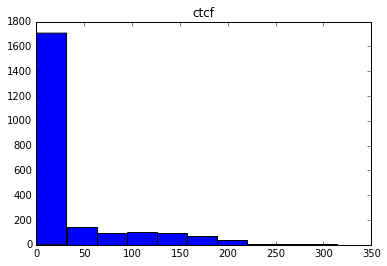

Average value with zeros:  18.4484494586
Average q-value w/o zeros:  32.7459977891


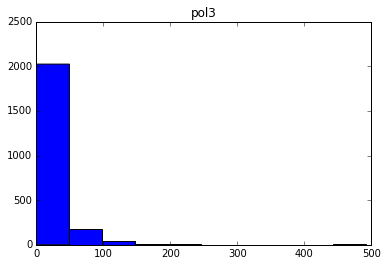

Average value with zeros:  7.85520705106
Average q-value w/o zeros:  12.7569910079


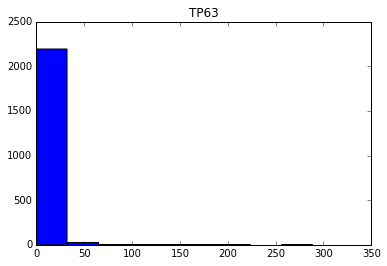

Average value with zeros:  1.2637209419
Average q-value w/o zeros:  6.21466229437


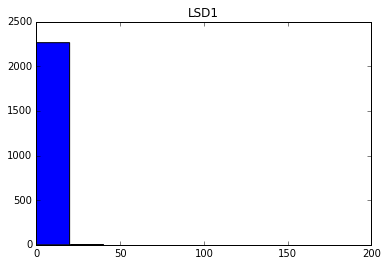

Average value with zeros:  29.2616054665
Average q-value w/o zeros:  53.5716096857


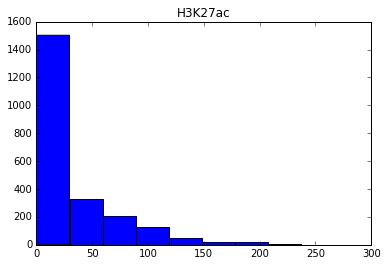

Average value with zeros:  3.58732474912
Average q-value w/o zeros:  13.2742700814


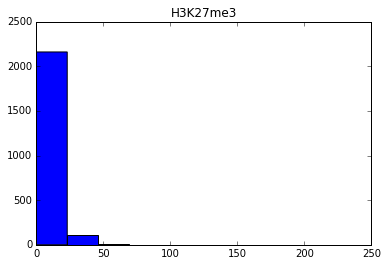

Average value with zeros:  10.7180672403
Average q-value w/o zeros:  15.2577999812


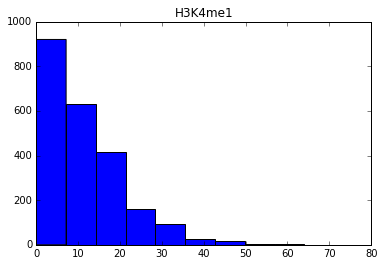

Average value with zeros:  105.933431734
Average q-value w/o zeros:  176.841114548


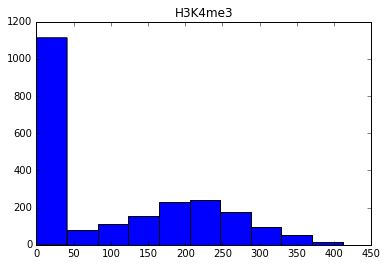

Average value with zeros:  16.7188760387
Average q-value w/o zeros:  28.2208665379


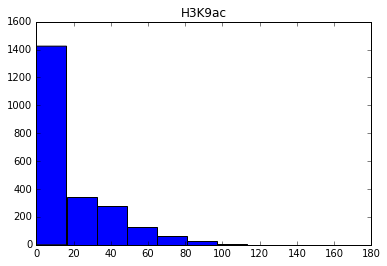

upperTriangle_noDiag thres2_max
(2582128, 11, 2)
(1289928, 11, 2)
(773956, 11, 2)
(515972, 11, 2)
Average value with zeros:  19.1889162192
Average q-value w/o zeros:  26.3905675847


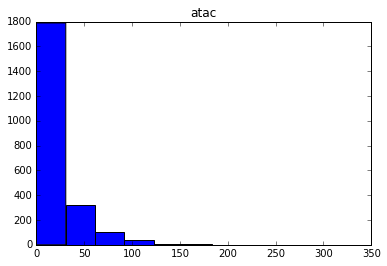

Average value with zeros:  26.138870559
Average q-value w/o zeros:  46.0011726646


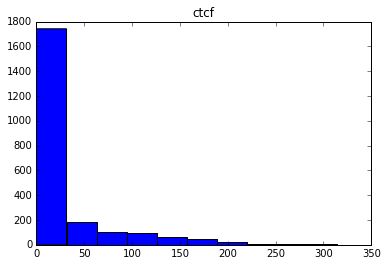

Average value with zeros:  16.41072375
Average q-value w/o zeros:  29.1290346562


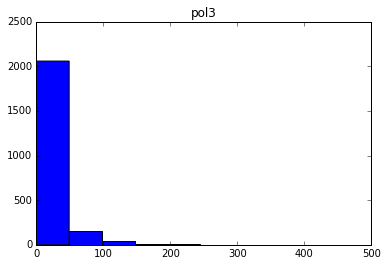

Average value with zeros:  6.64786035651
Average q-value w/o zeros:  10.7962392638


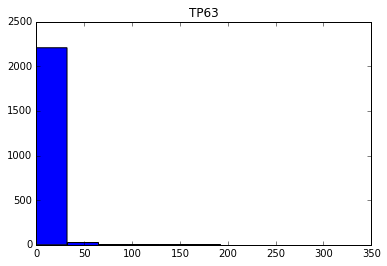

Average value with zeros:  1.21961975792
Average q-value w/o zeros:  5.99778374459


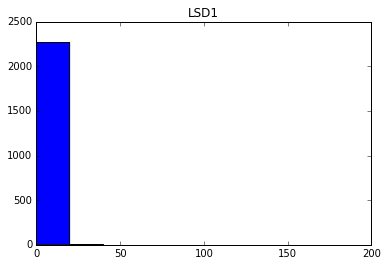

Average value with zeros:  26.4675582086
Average q-value w/o zeros:  48.456319299


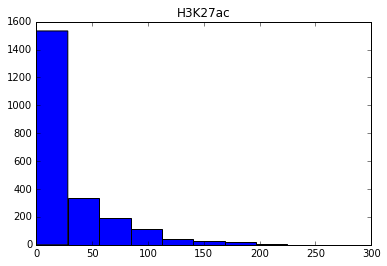

Average value with zeros:  3.21990819982
Average q-value w/o zeros:  11.9147091694


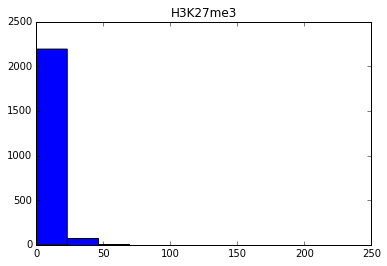

Average value with zeros:  8.79946596391
Average q-value w/o zeros:  12.5265580639


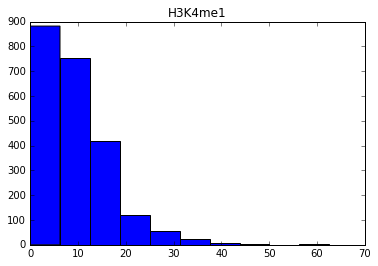

Average value with zeros:  101.908996184
Average q-value w/o zeros:  170.122879743


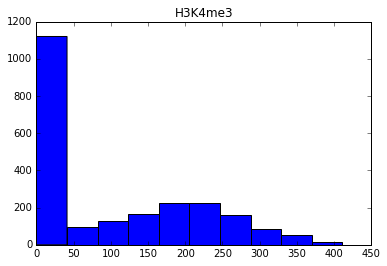

Average value with zeros:  14.533674309
Average q-value w/o zeros:  24.532323945


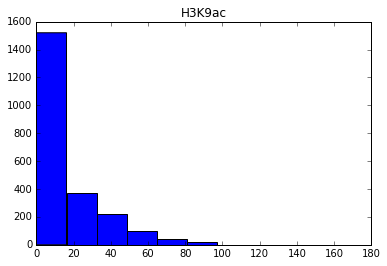

upperTriangle_noDiag thres2_mean
(2582128, 11, 2)
(1289928, 11, 2)
(773956, 11, 2)
(515972, 11, 2)
Average value with zeros:  116.543573944
Average q-value w/o zeros:  117.058797524


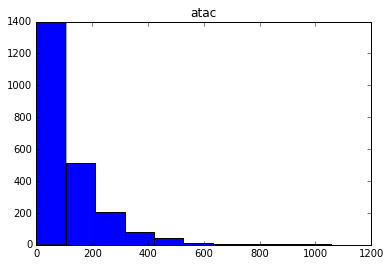

Average value with zeros:  92.8001760563
Average q-value w/o zeros:  93.0048522276


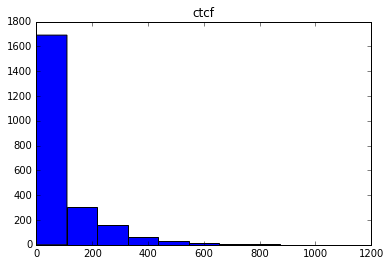

Average value with zeros:  241.500440141
Average q-value w/o zeros:  241.500440141


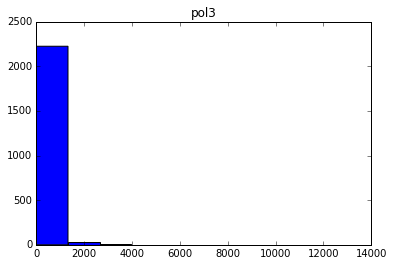

Average value with zeros:  23.3622359155
Average q-value w/o zeros:  24.9666039511


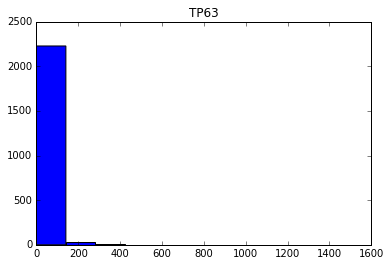

Average value with zeros:  40.9784330986
Average q-value w/o zeros:  41.0145374449


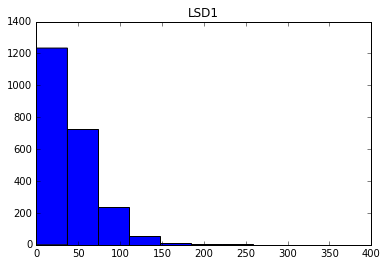

Average value with zeros:  297.378080986
Average q-value w/o zeros:  297.378080986


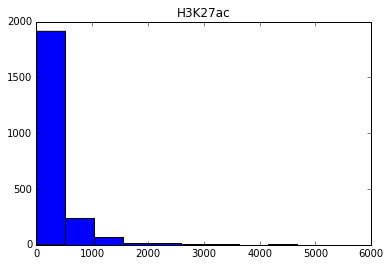

Average value with zeros:  239.871038732
Average q-value w/o zeros:  239.871038732


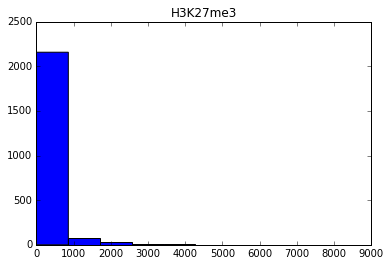

Average value with zeros:  209.150528169
Average q-value w/o zeros:  209.611821791


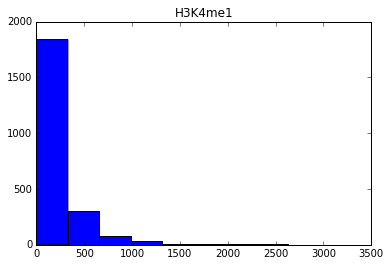

Average value with zeros:  968.580545775
Average q-value w/o zeros:  969.007045354


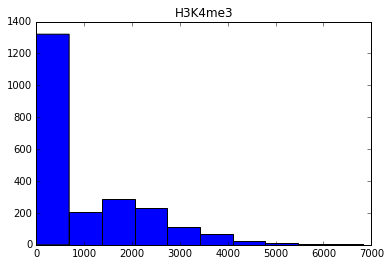

Average value with zeros:  176.617957746
Average q-value w/o zeros:  176.617957746


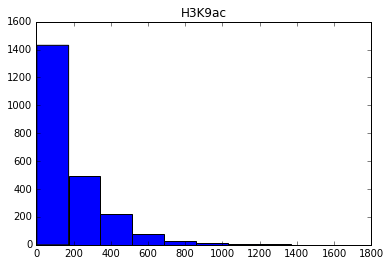

upperTriangle_noDiag reads
(2582128, 11, 2)
(1289928, 11, 2)
(773956, 11, 2)
(515972, 11, 2)


In [28]:
data_view=['all', 'upperTriangle', 'upperTriangle_noDiag']

NumberOfNodes=CaptureC_labels.shape[0]
for data in data_view:
    if data=='all':
        labels_all=np.zeros((NumberOfNodes**2,1))
        indx_all=np.zeros((NumberOfNodes**2,2))
        k1=0
        for i in range(NumberOfNodes):
            for j in range(NumberOfNodes):
                labels_all[k1]=CaptureC_labels[i][j]
                indx_all[k1,0]=int(i)
                indx_all[k1,1]=int(j)
                k1+=1
                
        train_nodes, vali_nodes, test_nodes = shuffle_nodes(labels_all, 0.5, 0.3)
        labels_train_all, labels_vali_all, labels_test_all = train_vali_test_1d(labels_all, train_nodes, vali_nodes, test_nodes)
        indx_train_all, indx_vali_all, indx_test_all = train_vali_test_2d(indx_all, train_nodes, vali_nodes, test_nodes)
        get_data(data, train_nodes, vali_nodes, test_nodes)
                
    if data=='upperTriangle':
        labels_upperTriangle=np.zeros(((NumberOfNodes**2+NumberOfNodes)/2,1))
        indx_upperTriangle=np.zeros(((NumberOfNodes**2+NumberOfNodes)/2,2))
        k1=0
        for i in range(NumberOfNodes):
            for j in range(i+1):
                labels_upperTriangle[k1]=CaptureC_labels[i][j]
                indx_upperTriangle[k1,0]=int(i)
                indx_upperTriangle[k1,1]=int(j)
                k1+=1
                    
        train_nodes, vali_nodes, test_nodes = shuffle_nodes(labels_upperTriangle, 0.5, 0.3)
        labels_train_upperTriangle, labels_vali_upperTriangle, labels_test_upperTriangle = train_vali_test_1d(labels_upperTriangle, train_nodes, vali_nodes, test_nodes)
        indx_train_upperTriangle, indx_vali_upperTriangle, indx_test_upperTriangle = train_vali_test_2d(indx_upperTriangle, train_nodes, vali_nodes, test_nodes)
        get_data(data, train_nodes, vali_nodes, test_nodes)
       
    if data=='upperTriangle_noDiag': 
        labels_upperTriangle_noDiag=np.zeros(((NumberOfNodes**2-NumberOfNodes)/2,1))
        indx_upperTriangle_noDiag=np.zeros(((NumberOfNodes**2-NumberOfNodes)/2,2))
        k1=0
        for i in range(NumberOfNodes):
            for j in range(i+1):
                if i!=j:
                    labels_upperTriangle_noDiag[k1]=CaptureC_labels[i][j]
                    indx_upperTriangle_noDiag[k1,0]=int(i)
                    indx_upperTriangle_noDiag[k1,1]=int(j)
                    k1+=1
                        
        train_nodes, vali_nodes, test_nodes = shuffle_nodes(labels_upperTriangle_noDiag, 0.5, 0.3)
        labels_train_upperTriangle_noDiag, labels_vali_upperTriangle_noDiag, labels_test_upperTriangle_noDiag = train_vali_test_1d(labels_upperTriangle_noDiag, train_nodes, vali_nodes, test_nodes)
        indx_train_upperTriangle_noDiag, indx_vali_upperTriangle_noDiag, indx_test_upperTriangle_noDiag = train_vali_test_2d(indx_upperTriangle_noDiag, train_nodes, vali_nodes, test_nodes)
        get_data(data, train_nodes, vali_nodes, test_nodes)
        

In [107]:
np.save('labels_train_all.npy', labels_train_all)
np.save('labels_vali_all.npy', labels_vali_all)
np.save('labels_test_all.npy', labels_test_all)
np.save('indx_train_all.npy', indx_train_all)
np.save('indx_vali_all.npy', indx_vali_all)
np.save('indx_test_all.npy', indx_test_all)        

np.save('labels_train_upperTriangle.npy', labels_train_upperTriangle)
np.save('labels_vali_upperTriangle.npy', labels_vali_upperTriangle)
np.save('labels_test_upperTriangle.npy', labels_test_upperTriangle)
np.save('indx_train_upperTriangle.npy', indx_train_upperTriangle)
np.save('indx_vali_upperTriangle.npy', indx_vali_upperTriangle)
np.save('indx_test_upperTriangle.npy', indx_test_upperTriangle)
        
np.save('labels_train_upperTriangle_noDiag.npy', labels_train_upperTriangle_noDiag)
np.save('labels_vali_upperTriangle_noDiag.npy', labels_vali_upperTriangle_noDiag)
np.save('labels_test_upperTriangle_noDiag.npy', labels_test_upperTriangle_noDiag)
np.save('indx_train_upperTriangle_noDiag.npy', indx_train_upperTriangle_noDiag)
np.save('indx_vali_upperTriangle_noDiag.npy', indx_vali_upperTriangle_noDiag)
np.save('indx_test_upperTriangle_noDiag.npy', indx_test_upperTriangle_noDiag)

In [29]:
print labels_all.shape
print labels_train_all.shape
print labels_vali_all.shape
print labels_test_all.shape

print indx_all.shape
print indx_train_all.shape
print indx_vali_all.shape
print indx_test_all.shape


print labels_upperTriangle.shape
print labels_train_upperTriangle.shape
print labels_vali_upperTriangle.shape
print labels_test_upperTriangle.shape

print indx_upperTriangle.shape
print indx_train_upperTriangle.shape
print indx_vali_upperTriangle.shape
print indx_test_upperTriangle.shape


print labels_upperTriangle_noDiag.shape
print labels_train_upperTriangle_noDiag.shape
print labels_vali_upperTriangle_noDiag.shape
print labels_test_upperTriangle_noDiag.shape

print indx_upperTriangle_noDiag.shape
print indx_train_upperTriangle_noDiag.shape
print indx_vali_upperTriangle_noDiag.shape
print indx_test_upperTriangle_noDiag.shape



(5161984, 1)
(2580992, 1)
(1548595, 1)
(1032397, 1)
(5161984, 2)
(2580992, 2)
(1548595, 2)
(1032397, 2)
(2582128, 1)
(1291064, 1)
(774638, 1)
(516426, 1)
(2582128, 2)
(1291064, 2)
(774638, 2)
(516426, 2)
(2579856, 1)
(1289928, 1)
(773956, 1)
(515972, 1)
(2579856, 2)
(1289928, 2)
(773956, 2)
(515972, 2)


In [30]:
print np.sum(labels_train_upperTriangle_noDiag==1)
print np.sum(labels_train_upperTriangle_noDiag==0)
print np.sum(labels_train_upperTriangle==1)
print np.sum(labels_train_upperTriangle==0)
print np.sum(labels_train_all==1)
print np.sum(labels_train_all==0)

11001
1278927
12077
1278987
23056
2557936


In [7]:
# builds adjacency matrix 
def reconstructCaptureC(indx, labels, matrixSize):

    # Initialize matrix (promoter x promoter)
    matrix=np.zeros((matrixSize, matrixSize)) #  number of promoters in chr 1

    # Fill (promoter x promoter) matrix with q-values of promoter-promoter interaction
    k=0
    for i in indx:
        matrix[int(i[0]), int(i[1])]=labels[k]
        k+=1
    print "Some tests on adjacency matrix:"
    # 1. Check if the matrix is symmetric:
    if (matrix.transpose() == matrix).all() == True:
        print "Adjacency matrix is symmetric"

    return matrix

In [8]:
def printMatrix(Matrix, ylabel, QuantileValue, LowerUpperLimit, title=''):
    #vmaxLim=mquantiles(Matrix,[0.99])[0]
    Lim=mquantiles(Matrix,[QuantileValue])[0]
    print Matrix.max()
    print np.shape(Matrix)
    print "Limit:", Lim
    fig, ax = plt.subplots()
    fig.subplots_adjust(top=0.8)
    if LowerUpperLimit == 'lower':
        m = ax.matshow(Matrix, origin="bottom", #norm=colors.LogNorm(),  #norm=colors.SymLogNorm(1),
               cmap="RdYlBu_r", vmin=Lim)
    else:
        m = ax.matshow(Matrix, origin="bottom", #norm=colors.LogNorm(),  #norm=colors.SymLogNorm(1),
               cmap="RdYlBu_r", vmax=Lim) # cmap="RdYlBu_r"


    ax.axhline(-0.5, color="#000000", linewidth=1, linestyle="--")
    ax.axvline(-0.5, color="#000000", linewidth=1, linestyle="--")

    cb = fig.colorbar(m)
    cb.set_label(ylabel)

    ax.set_ylim((-0.5, len(Matrix) - 0.5))
    ax.set_xlim((-0.5, len(Matrix) - 0.5))
    
    plt.title(title)
    plt.show()
    return



# Tests for labels

In [98]:
all_matrix=reconstructCaptureC(np.vstack((indx_train_all, indx_vali_all, indx_test_all)), np.vstack((labels_train_all, labels_vali_all, labels_test_all)), NumberOfNodes)
upperTriag_matrix=reconstructCaptureC(np.vstack((indx_train_upperTriangle, indx_vali_upperTriangle, indx_test_upperTriangle)), np.vstack((labels_train_upperTriangle, labels_vali_upperTriangle, labels_test_upperTriangle)), NumberOfNodes)
upperTriag_noDiag_matrix=reconstructCaptureC(np.vstack((indx_train_upperTriangle_noDiag, indx_vali_upperTriangle_noDiag, indx_test_upperTriangle_noDiag)), np.vstack((labels_train_upperTriangle_noDiag, labels_vali_upperTriangle_noDiag, labels_test_upperTriangle_noDiag)), NumberOfNodes)

Some tests on adjacency matrix:
Adjacency matrix is symmetric
Some tests on adjacency matrix:
Some tests on adjacency matrix:


In [102]:
np.sum((all_matrix==CaptureC_labels)==True)==CaptureC_labels.shape[0]**2

True

In [105]:
x=upperTriag_matrix+upperTriag_matrix.T
for i in range(x.shape[0]):
    x[i,i]=x[i,i]/2
np.sum((x==CaptureC_labels)==True)==CaptureC_labels.shape[0]**2


True

In [106]:
x=upperTriag_noDiag_matrix+upperTriag_noDiag_matrix.T
for i in range(x.shape[0]):
    x[i,i]=CaptureC_labels.max()
np.sum((x==CaptureC_labels)==True)==CaptureC_labels.shape[0]**2


True

# Predictions

In [5]:
preds_test_noDist=np.load('model_predictions/test_set_upperTriangle_noDiag_reads_without_distances.npy')
preds_test_Dist=np.load('model_predictions/test_set_upperTriangle_noDiag_reads_with_distances.npy')
indx_test_upperTriangle_noDiag=np.load('indx_test_upperTriangle_noDiag.npy')

In [10]:
NumberOfNodes=2272
preds_test_noDist=reconstructCaptureC(indx_test_upperTriangle_noDiag, preds_test_noDist, NumberOfNodes)
#preds_test_Dist=reconstructCaptureC(indx_test_upperTriangle_noDiag, preds_test_noDist, NumberOfNodes)

ValueError: setting an array element with a sequence.

0.999728381634
(2272, 2272)
Limit: 0.999728381634


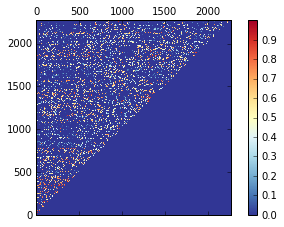

In [16]:
printMatrix(preds_test, '', 1, 1, title='')

In [37]:
def binarize(matrix, thres=0.5):
    copy.copy(matrix)
    matrix[matrix <= thres] = 0
    matrix[matrix > thres] = 1    
    return matrix

1.0
(2272, 2272)
Limit: 1.0


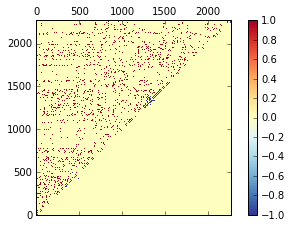

In [38]:
printMatrix(binarize(preds_test)-set_diag_to_value(CaptureC_labels,0), '', 1, 1, title='')

1.0
(100, 100)
Limit: 1.0


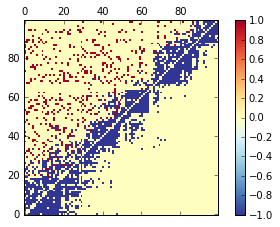

In [39]:
subset=(binarize(preds_test)-set_diag_to_value(CaptureC_labels,0))[[i for i in range(100)]][:, [i for i in range(100)]]
printMatrix(subset, '', 1, i, title='')

1.0
(100, 100)
Limit: 1.0


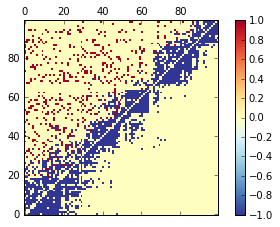

In [43]:
subset=(binarize(preds_test)-set_diag_to_value(CaptureC_labels,0))[[i for i in range(100)]][:, [i for i in range(100)]]
printMatrix(subset, '', 1, i, title='')

In [56]:
def binarize(matrix, thres):
    matrix=copy.copy(matrix)
    matrix[matrix <= thres] = 0
    matrix[matrix > thres] = 1    
    return matrix

1.0
(100, 100)
Limit: 1.0


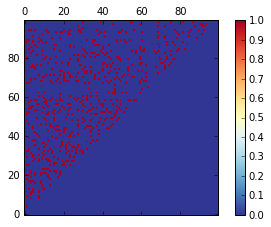

In [57]:
subset=(binarize(preds_test, 0))[[i for i in range(100)]][:, [i for i in range(100)]]
printMatrix(subset, '', 1, i, title='')

1.0
(100, 100)
Limit: 1.0


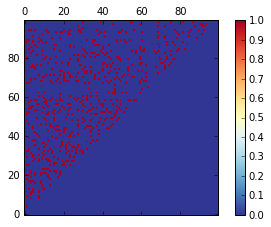

In [63]:
subset=(binarize(preds_test, 0.99999))[[i for i in range(100)]][:, [i for i in range(100)]]
printMatrix(subset, '', 1, i, title='')

(array([      0.,       0.,       0.,       0.,       0.,  221109.,
              0.,       0.,       0.,       0.]),
 array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5]),
 <a list of 10 Patch objects>)

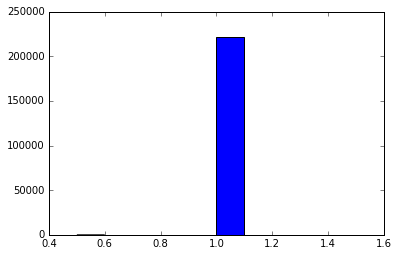

In [67]:
preds_raveled = preds_test.ravel()
plt.hist(preds_raveled[preds_raveled>0])


1.0
(100, 100)
Limit: 1.0


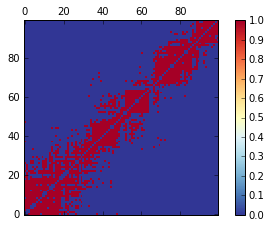

In [41]:
subset=CaptureC_labels[[i for i in range(100)]][:, [i for i in range(100)]]
printMatrix(subset, '', 1, i, title='')